# Coastal Change

*****
### This Notebook:  

- Highlights a simple method for detecting coastal change between two timeframes
- Visualizes water classification for two timeframes
- Visualizes water classification changes between timeframes
------  
### Motivation:  

International agencies like World Bank, UNEP, and USAID are currently reporting and addressing the problem of coastal erosion near Lomé, Togo.  The links listed below are references from these agencies regarding coastal erosion in Togo and coastal erosion as a world wide phenomena.  

- *"West Africa Coastal Erosion Project launched in Togo" (2016) *  [- link](http://www.ndf.fi/news/west-africa-coastal-erosion-project-launched-togo)
- *Agreement to Erosion Adaptation Project* (2016)  [- link](http://pubdocs.worldbank.org/en/493191479316551864/WACA-Lom%C3%A9-Communiqu%C3%A9-2016-English.pdf)
- World Bank WACA program brochure (2015)  [- link](http://pubdocs.worldbank.org/en/622041448394069174/1606426-WACA-Brochure.pdf)
- UNEP - Technologies for climate change adaption (2010)  [- link](http://www.unep.org/pdf/TNAhandbook_CoastalErosionFlooding.pdf)  
- USAID - Adapting to Coastal Climate Change (2009) -  [- link](http://www.crc.uri.edu/download/CoastalAdaptationGuide.pdf)  
- UNEP - Coastal Erosion and Climate Change in Western Africa(2002) -  [- link](http://www.unep.org/dewa/africa/publications/aeo-1/121.htm)
  
-------
### Algorithmic Profile:  
  
- This algorithm generates a water change product.
- The product is derived from Landsat7 Collection 1, Tier 2 sr imagery taken from USGS data holdings.    
- Utilizes WOFS for water detection.
-------  
### Process:  

- Load in a year's worth of data for years `y1` and `y2`, 
- Reduce noise by temporal compositing of both `y1` and `y2` to yield `y1_composite` and `y2_composite` .(This removes clouds, scanline errors, and statistical anomalies)      
- Run WOFS water classifier on `y1_composite` and `y2_composite`, to yield `y1_water` and `y2_water`. These outputs contain a 1 for water, and 0 for not water.     
- Subtract `y1_water` from `y2_water` to yield a `coastal_change` product. Where 0 represents no change, 1 represents water gain, and -1 represents water loss. 
*****  

> **Flow Diagram**
![](diagrams/rainy_demo/algo_nb3.png)

In [1]:
%matplotlib inline

from datetime import datetime
import numpy as np

import datacube
import utils.data_cube_utilities.dc_utilities as utils

from utils.data_cube_utilities.dc_mosaic import create_mosaic, ls7_unpack_qa
from utils.data_cube_utilities.dc_water_classifier import wofs_classify

# import warnings; warnings.simplefilter('ignore')

In [2]:
start_time = datetime.now()
print("Start time: " + str(start_time))

Start time: 2018-05-15 15:00:26.946126


In [3]:
# Initialize data cube object
dc = datacube.Datacube(config='/home/localuser/.datacube.conf', app='dc-coastal-erosion')

# Set query parameters
platform        = 'LANDSAT_7'
product_type    = 'ls7_ledaps_togo'

# Select minimum and maximum longitudes and latitudes.
min_lon         = 1.1919
max_lon         = 1.4509
min_lat         = 6.0809
max_lat         = 6.2218

In [4]:
start_date      = datetime.strptime('2000-01-01', '%Y-%m-%d')
end_date        = datetime.strptime('2000-12-31', '%Y-%m-%d')

In [5]:
measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']
# Retrieve data from Data Cube
dataset_in_2000 = dc.load(platform=platform,
                          product=product_type,
                          time=(start_date, end_date),
                          lon=(min_lon, max_lon),
                          lat=(min_lat, max_lat), measurements=measurements)

In [6]:
start_date      = datetime.strptime('2015-01-01', '%Y-%m-%d')
end_date        = datetime.strptime('2015-12-31', '%Y-%m-%d')

In [7]:
# Retrieve data from Data Cube
dataset_in_2015 = dc.load(platform=platform,
                          product=product_type,
                          time=(start_date, end_date),
                          lon=(min_lon, max_lon),
                          lat=(min_lat, max_lat), measurements=measurements)

In [8]:
# Only keep pixels that are clear or have water.
clear_xarray  = ls7_unpack_qa(dataset_in_2000.pixel_qa, "clear")  
water_xarray  = ls7_unpack_qa(dataset_in_2000.pixel_qa, "water")
clean_mask_2000 = np.logical_or(clear_xarray.values.astype(bool),
                           water_xarray.values.astype(bool))

clear_xarray  = ls7_unpack_qa(dataset_in_2015.pixel_qa, "clear")  
water_xarray  = ls7_unpack_qa(dataset_in_2015.pixel_qa, "water")
clean_mask_2015 = np.logical_or(clear_xarray.values.astype(bool),
                           water_xarray.values.astype(bool))

# Remove noise from images by using appropriate data within the dataset to replace "dirty" data.
mosaic_2000 = create_mosaic(dataset_in_2000, clean_mask=clean_mask_2000)
mosaic_2015 = create_mosaic(dataset_in_2015, clean_mask=clean_mask_2015)

In [9]:
water_class_2000 = wofs_classify(mosaic_2000, mosaic=True, no_data=np.nan)
water_class_2015 = wofs_classify(mosaic_2015, mosaic=True, no_data=np.nan)

wofs_2000 = water_class_2000.wofs.values
wofs_2015 = water_class_2015.wofs.values

In [12]:
coastal_change = water_class_2015 - water_class_2000

In [26]:
import matplotlib.pyplot as plt 
def plot_data_array_with_aspect(da):
    fig, ax = plt.subplots(figsize=(15,8))
    ax.set_aspect('equal')
    da.plot()

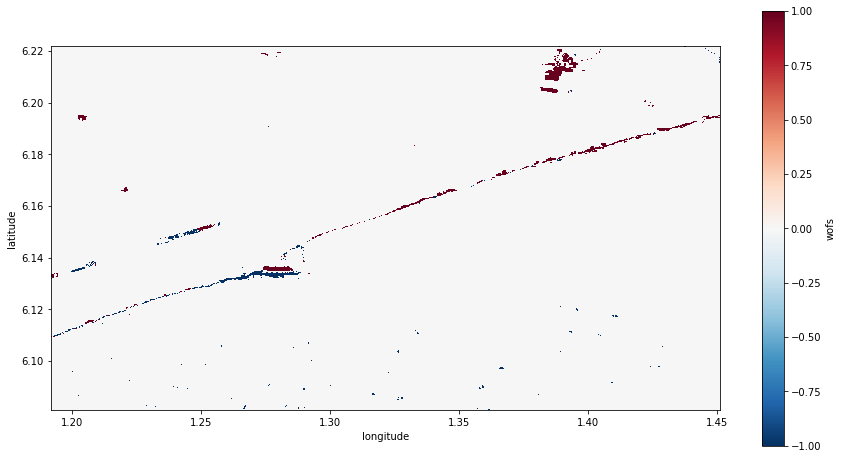

In [28]:

# -1 -> water to coast
#  0 -> no change
#  1 -> coast to water (Coastal Erosion)

plot_data_array_with_aspect( coastal_change.wofs )

In [34]:
coastline_2000 = np.zeros(wofs_2000.shape)

for i in range(wofs_2000.shape[0]):
    for j in range(wofs_2000.shape[1]):
        pixel = wofs_2000[i,j]
        if pixel == 0 and np.nansum(wofs_2000[i-1:i+2, j-1:j+2]) >= 1 and np.nansum(wofs_2000[i-1:i+2, j-1:j+2]) <= 5:
            coastline_2000[i,j] = 1
            
coastline_2015 = np.zeros(wofs_2015.shape)

for i in range(wofs_2015.shape[0]):
    for j in range(wofs_2015.shape[1]):
        pixel = wofs_2015[i,j]
        if pixel == 0 and np.nansum(wofs_2015[i-1:i+2, j-1:j+2]) >= 1 and np.nansum(wofs_2015[i-1:i+2, j-1:j+2]) <= 5:
            coastline_2015[i,j] = 1

In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [22]:
from pylab import imshow

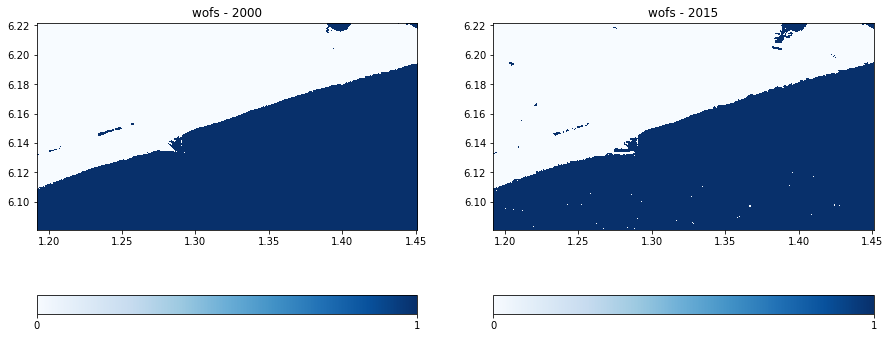

In [32]:
fig = plt.figure(figsize =  (15,8))
a=fig.add_subplot(1,2,1) 

imgplot = plt.imshow(wofs_2000, cmap='Blues',
                     extent=[water_class_2000.longitude.values.min(), 
                             water_class_2000.longitude.values.max(),
                             water_class_2000.latitude.values.min(),
                             water_class_2000.latitude.values.max()])
a.set_title('wofs - 2000')
plt.colorbar(ticks=[0,1], orientation ='horizontal')
a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(wofs_2015, cmap='Blues',
                     extent=[water_class_2015.longitude.values.min(), 
                             water_class_2015.longitude.values.max(),
                             water_class_2015.latitude.values.min(),
                             water_class_2015.latitude.values.max()])
#imgplot.set_clim(0.0,1.0)
a.set_title('wofs - 2015')
plt.colorbar(ticks=[0,1], orientation='horizontal')
plt.savefig('wofs_compare.png')

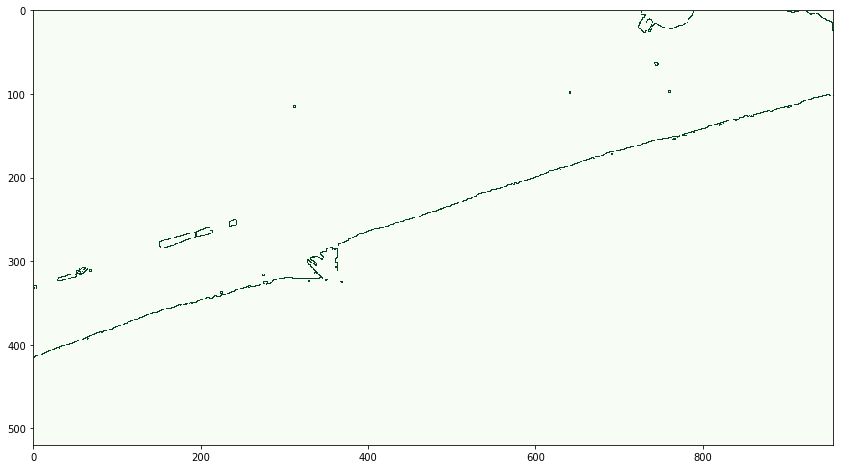

In [36]:
fig = plt.figure(figsize =  (15,8))
plt.imshow(coastline_2000, cmap='Greens')

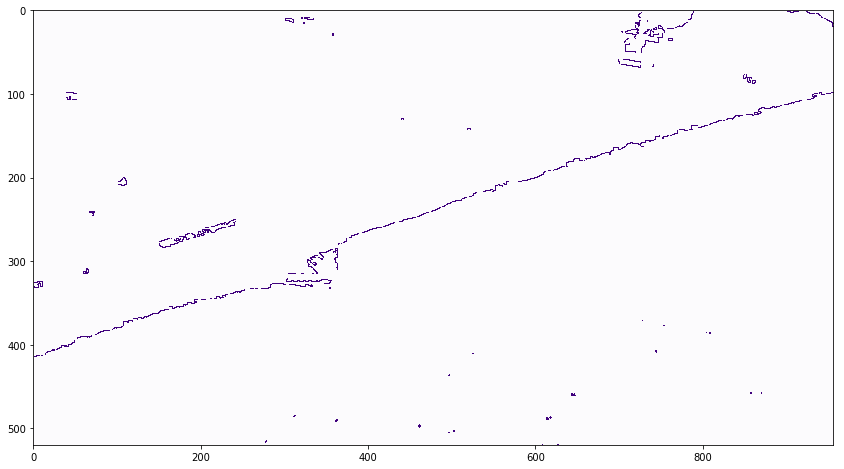

In [38]:
fig = plt.figure(figsize =  (15,8))
plt.imshow(coastline_2015, cmap='Purples')

In [39]:
mosaic_2000

<xarray.Dataset>
Dimensions:    (latitude: 520, longitude: 957)
Coordinates:
  * latitude   (latitude) float64 6.222 6.222 6.221 6.221 6.221 6.22 6.22 ...
  * longitude  (longitude) float64 1.192 1.192 1.192 1.193 1.193 1.193 1.193 ...
Data variables:
    red        (latitude, longitude) float32 1600.0 1532.0 1515.0 1910.0 ...
    green      (latitude, longitude) float32 1203.0 1146.0 1165.0 1492.0 ...
    blue       (latitude, longitude) float32 820.0 838.0 802.0 1014.0 943.0 ...
    nir        (latitude, longitude) float32 2650.0 2575.0 2650.0 2764.0 ...
    swir1      (latitude, longitude) float32 3541.0 3361.0 3384.0 3429.0 ...
    swir2      (latitude, longitude) float32 2827.0 2615.0 2615.0 2827.0 ...
    pixel_qa   (latitude, longitude) int32 66 66 66 66 66 66 66 66 66 66 66 ...

In [40]:
mosaic_rgb_2000 = np.array([mosaic_2000.red.values, mosaic_2000.green.values, mosaic_2000.blue.values])

In [41]:
mosaic_rgb_2000

array([[[1600., 1532., 1515., ...,  837.,  855.,  621.],
        [1566., 1497., 1636., ...,  873.,  855.,  682.],
        [1497., 1549., 1636., ...,  855.,  855.,  682.],
        ...,
        [ 413.,  373.,  433., ...,  398.,  378.,  398.],
        [ 413.,  393.,  393., ...,  418.,  398.,  378.],
        [ 413.,  393.,  393., ...,  418.,  358.,  378.]],

       [[1203., 1146., 1165., ...,  873.,  873.,  750.],
        [1146., 1165., 1183., ...,  893.,  893.,  750.],
        [1126., 1146., 1146., ...,  893.,  873.,  750.],
        ...,
        [ 514.,  514.,  492., ...,  498.,  520.,  475.],
        [ 492.,  492.,  492., ...,  498.,  475.,  475.],
        [ 537.,  492.,  492., ...,  498.,  475.,  453.]],

       [[ 820.,  838.,  802., ...,  732.,  750.,  729.],
        [ 802.,  786.,  786., ...,  732.,  750.,  729.],
        [ 786.,  802.,  802., ...,  750.,  750.,  709.],
        ...,
        [ 568.,  568.,  547., ...,  554.,  575.,  575.],
        [ 568.,  568.,  568., ...,  575.,  57